In [1]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import skimage
from skimage import util
import skimage.io as io
from skimage import exposure

import sys

## Read data

In [12]:
SideLight_42835=io.imread("../data/42835_chanel_1_SideLight.tif")
BottomLight_42835=io.imread("../data/42835_chanel_2_BottomLight.tif")
SideLight_42834=io.imread("../data/42834_chanel_1_SideLight.tif")
BottomLight_42834=io.imread("../data/42834_chanel_2_BottomLight.tif")

images_dict={"SideLight_42835":SideLight_42835,
             "SideLight_42834":SideLight_42834,
             "BottomLight_42835":BottomLight_42835,
             "BottomLight_42834":BottomLight_42834}

Image stacks have an identical dimensions: 66 frames (one frame every 297 s circa 5 minutes), images 2208x2752 pixels

In [53]:
print("SideLight_42834={}\n SideLight_42835={}\n BottomLight_42834={} \n BottomLight_42835={}".format(SideLight_42834.shape,SideLight_42835.shape,BottomLight_42834.shape,BottomLight_42835.shape))

SideLight_42834=(66, 2208, 2752)
 SideLight_42835=(66, 2208, 2752)
 BottomLight_42834=(66, 2208, 2752) 
 BottomLight_42835=(66, 2208, 2752)


## Image Median Intesity

In [13]:
def med_image(images,name,step):
    num_frame=images.shape[0]
    Med_list=[]
    frame=0
    for i in range(0,num_frame,step):
        Med_list.append({"frame":frame,"median":np.median(images[i,:,:])})
        frame=frame+1
    return pd.DataFrame(Med_list)

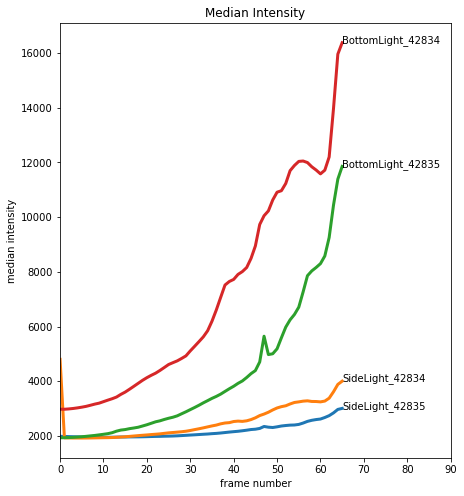

In [25]:
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(7,8))

for (name,images) in images_dict.items():
    Med_region=med_image(images,name,1)
    ax.plot(Med_region["frame"],Med_region["median"],linewidth=3,label=name)
    ax.text(Med_region.iloc[-1]["frame"],Med_region.iloc[-1]["median"],name)
ax.set_xlim([0,90])
ax.set_xlabel("frame number")
ax.set_ylabel("median intensity")
ax.set_title("Median Intensity")
fig.savefig("../figures/Compare_median_intensity.png")

## Display images per hour

In [42]:
def rescale_per_frame(img):
    vmin, vmax = np.percentile(img, q=(0, 99.9))
    #print(vmin, vmax)
    img_scaled = exposure.rescale_intensity(img,in_range=(vmin, vmax))
    return img_scaled

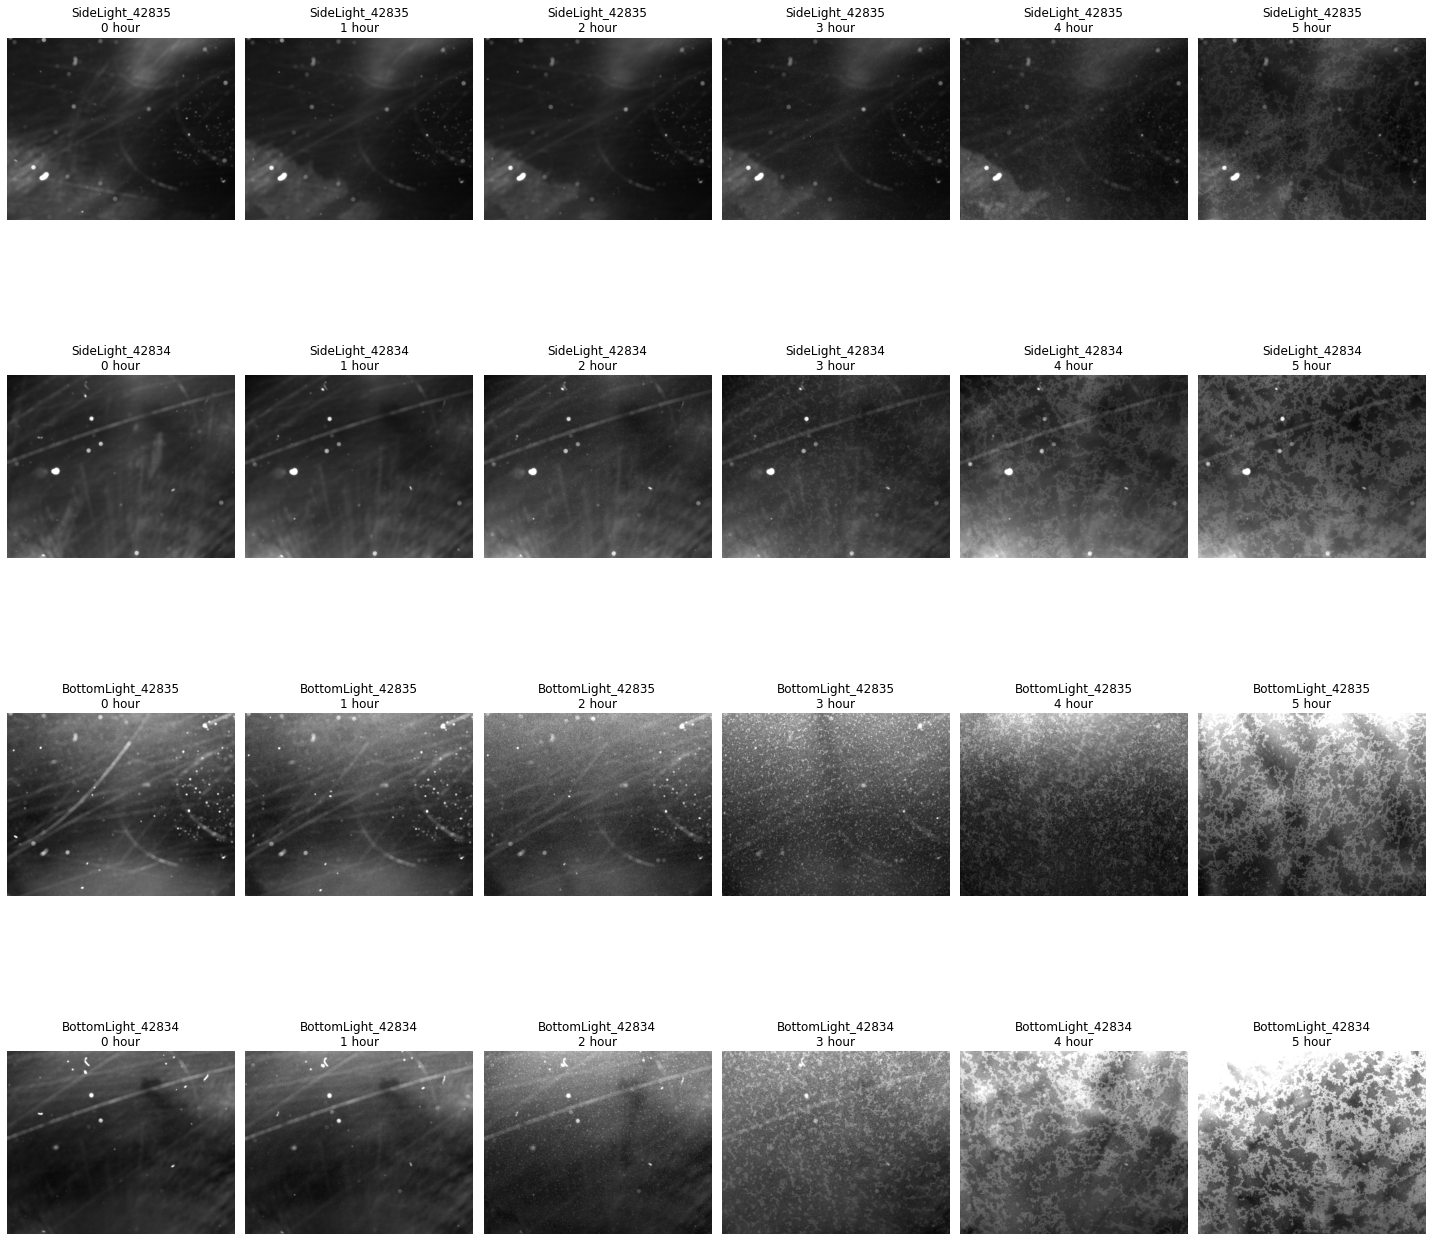

In [46]:
fig,ax= plt.subplots(nrows=4, ncols=6,figsize=(20,20))
    
row_number=0
for (name,images) in images_dict.items():
    col_number=0
    for t in range(0,66,12):
        ax[row_number,col_number].imshow(rescale_per_frame(images[t,:,:]),cmap="gray")
        ax[row_number,col_number].axis('off')
        ax[row_number,col_number].set_title(name+"\n"+str(col_number)+" hour")
        col_number=col_number+1
    row_number=row_number+1
fig.tight_layout()
fig.savefig("../figures/"+"Comparison_per_hour.png")

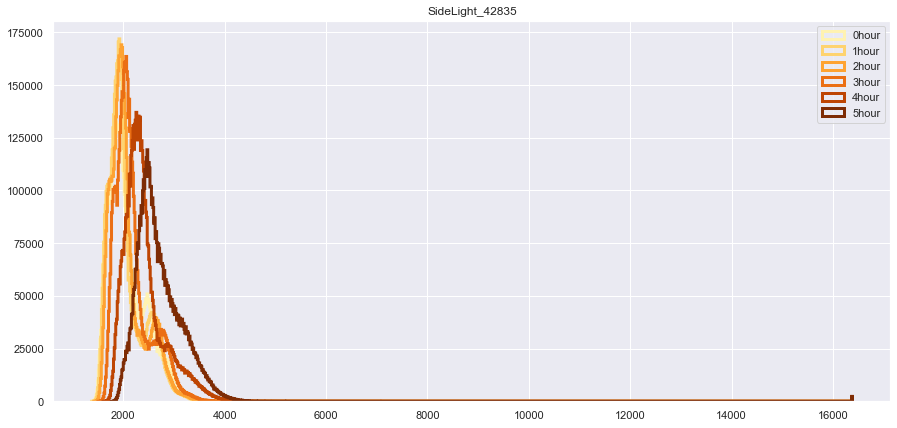

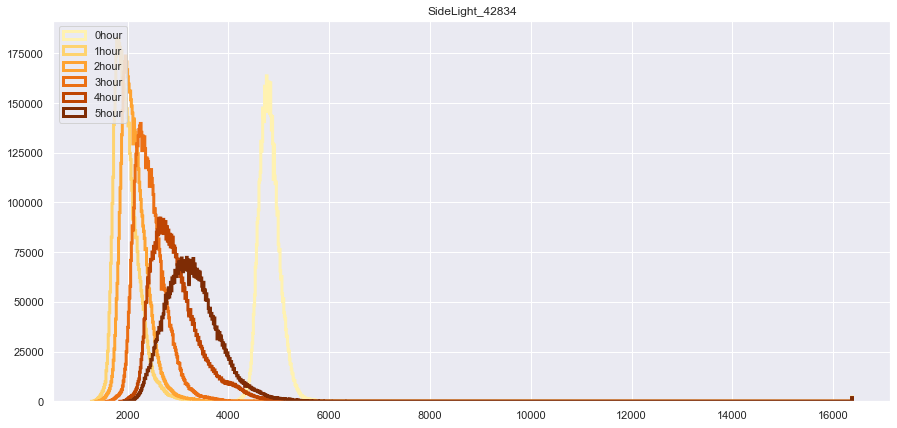

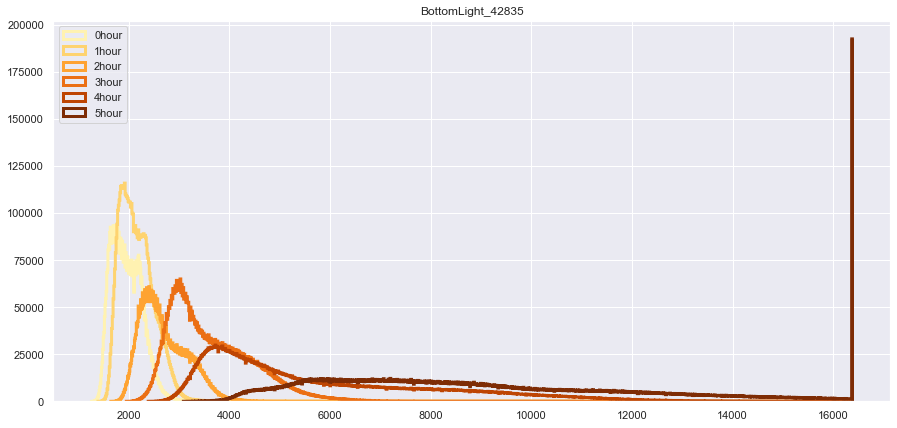

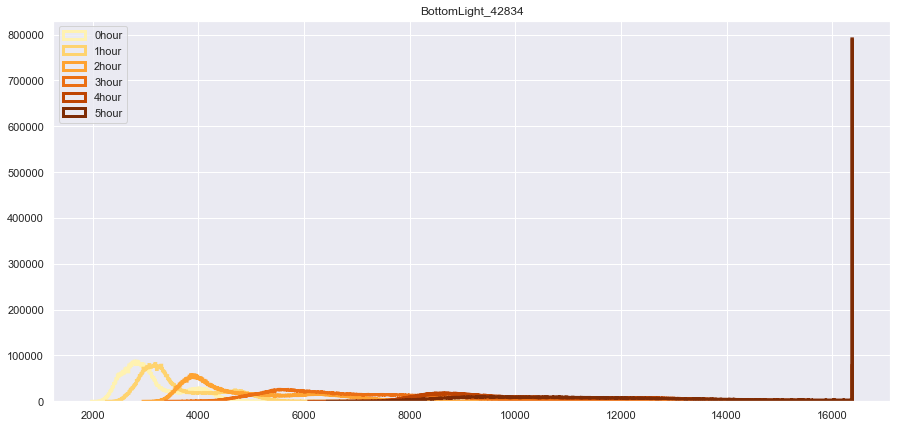

In [206]:
sns.set(font_scale=1)
row_number=0
for (name,images) in images_dict.items():
   
    fig,ax= plt.subplots(nrows=1, ncols=1,figsize=(15,7))
    count=0
    for t in range(0,66,12):
        ax.hist(images[t,:,:].ravel(),bins=1000,histtype='step',linewidth=3.0,color = plt.cm.YlOrBr((count+1)*40),label=str(count)+"hour")
        ax.set_title(name)
        count=count+1
    ax.legend()
    #sns.kdeplot(data=df_total,x="Int",hue="frame",common_norm=False,cmap="rocket",ax=ax[row_number])
#fig.tight_layout()
#fig.savefig("../figures/"+"Comparison_per_hour.png")

## Slice Plot

### Position of slice

In [133]:
Layer_width=200
Layer_hight=1000
Center=[SideLight_42834[0].shape[0]/2,SideLight_42834[0].shape[1]/2]
Rectangle_row=[int(Center[0]-Layer_width/2),int(Center[0]+Layer_width/2)]
Rectangle_col=[int(Center[1]-Layer_hight/2),int(Center[0]+Layer_hight/2)]
Rectangle_Layer={"min_row":int(Center[0]-Layer_width/2),
                 "min_col":int(Center[1]-Layer_hight/2),
                 "layer_width":Layer_width,
                 "layer_hight":Layer_hight}

Start_col=int(Center[1]-Layer_width/2)
Start_row=int(Center[0]-Layer_hight/2)
Rectange=[Start_col,Start_row,Layer_width,Layer_hight]

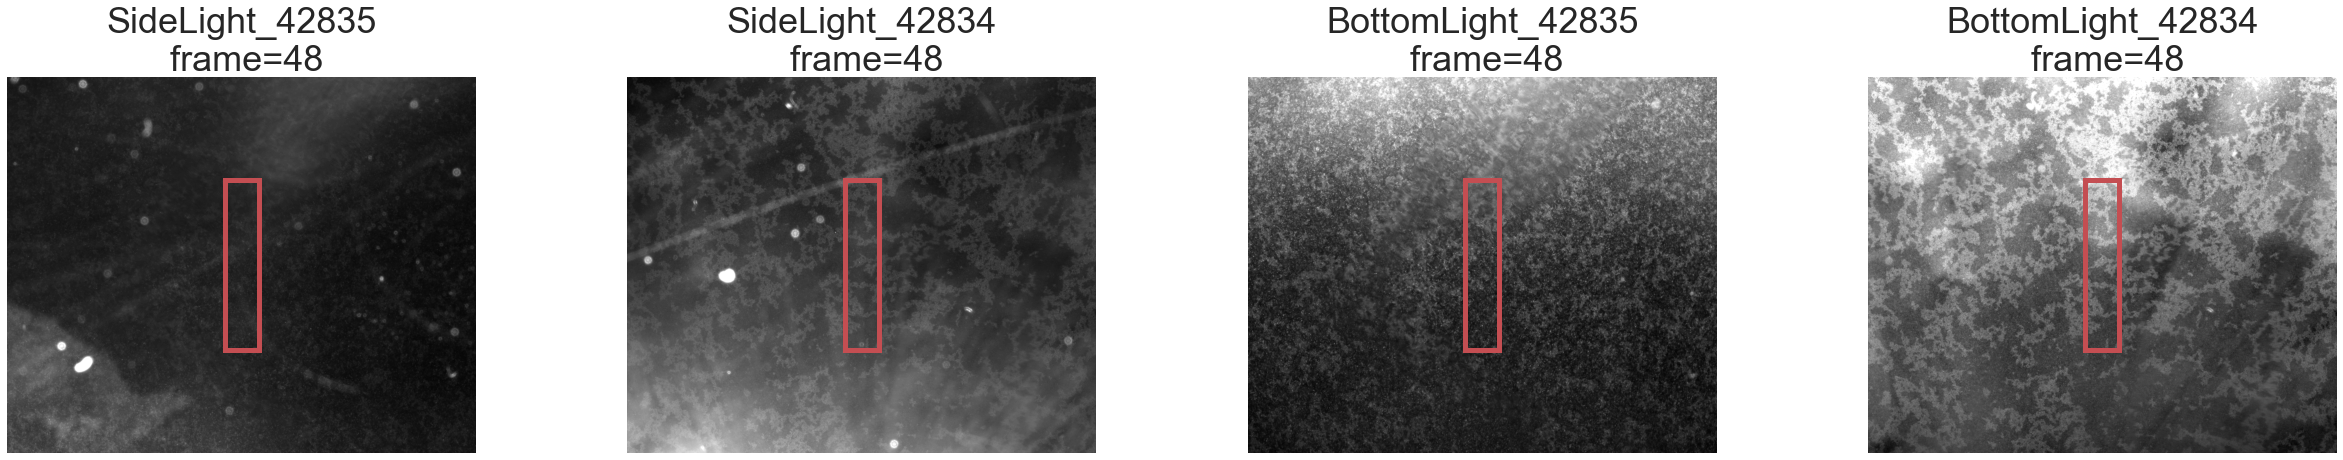

In [84]:
from matplotlib.patches import Rectangle
sns.set(font_scale=3)

def show_plane(ax, plane,rect,cmap="gray", title=None):
    ax.imshow(plane, cmap=cmap)
    
    # Create a Rectangle patch
    draw_rect =Rectangle((rect[0],rect[1]),rect[2],rect[3],linewidth=5,edgecolor='r',facecolor='none')
    ax.add_patch(draw_rect)
    ax.axis("off")
    if title:ax.set_title(title)
        
fig,ax=plt.subplots(nrows=1,ncols=4,figsize=(35,7))
counter=0
frame=48
for (name,images) in images_dict.items():
    show_plane(ax[counter],rescale_per_frame(images[frame]),Rectange,cmap="gray", title=name+"\n frame="+str(frame))
    counter=counter+1

fig.tight_layout()
fig.savefig("../figures/"+"Viz_layer.png")

In [172]:
def Plot_layer_time(img_stack,Rectangle_Layer,Step,plot_label):
    """
    img_stack: stack of the images
    Rectangle_Layer: dictionary describes selected region
        "min_row"
        "min_col"
        "layer_width"
        "layer_hight"
    
    """
    NumFrames=img_stack.shape[0]
    TimeFrame=range(0,NumFrames,Step)
    NumLayers=len(TimeFrame)
    
    ImgLayerStack=np.zeros([Rectangle_Layer["layer_hight"],NumLayers*Rectangle_Layer["layer_width"]])
    Interval=np.array([0,Rectangle_Layer["layer_width"]])
    
    
    # make a composite image stiched from the Roi for different time frames
    for t in TimeFrame:
        cut=img_stack[t,Rectangle_Layer["min_row"]:Rectangle_Layer["min_row"]+Rectangle_Layer["layer_hight"],Rectangle_Layer["min_col"]:Rectangle_Layer["min_col"]+Rectangle_Layer["layer_width"]].copy()
        ImgLayerStack[:,Interval[0]:Interval[1]]=exposure.adjust_gamma(cut,gamma=0.5)
        #rescale_per_frame(cut)
        #exposure.equalize_adapthist(cut,clip_limit=0.03)
        Interval=Interval+Rectangle_Layer["layer_width"]
    
    # make a plot
    plt.figure(figsize=(20,20))
    plt.imshow(ImgLayerStack,cmap=plt.cm.gray)    
    
    # put labels
    count=0
    text_y_coord=range(int(Rectangle_Layer["layer_width"]/2)-50,NumLayers*Rectangle_Layer["layer_width"],Rectangle_Layer["layer_width"])
    for y in text_y_coord:
        t="frame"+str(count*Step)
        plt.text(y,Rectangle_Layer["layer_hight"]+50,t,fontsize=12)
        count=count+1

    plt.axis('off')    
    plt.title(plot_label)
    plt.savefig("../figures/"+plot_label+".png",bbox_inches='tight')

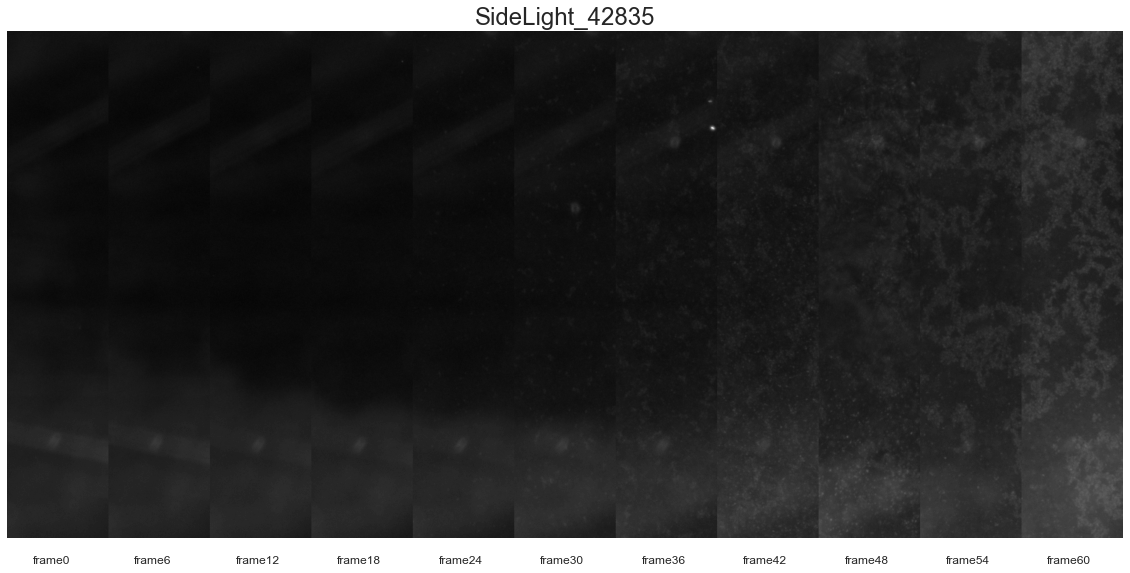

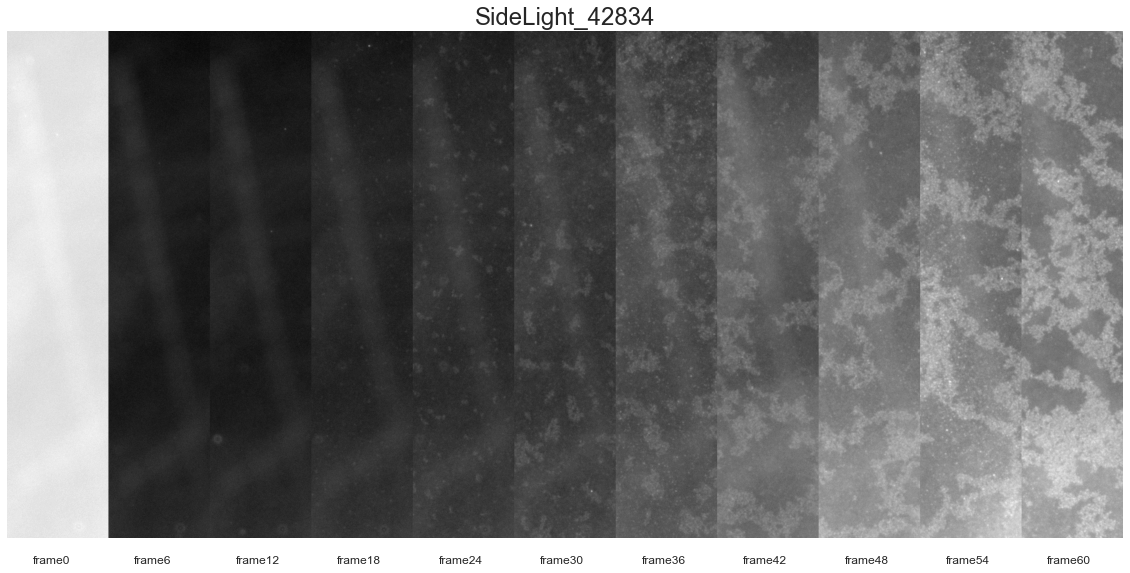

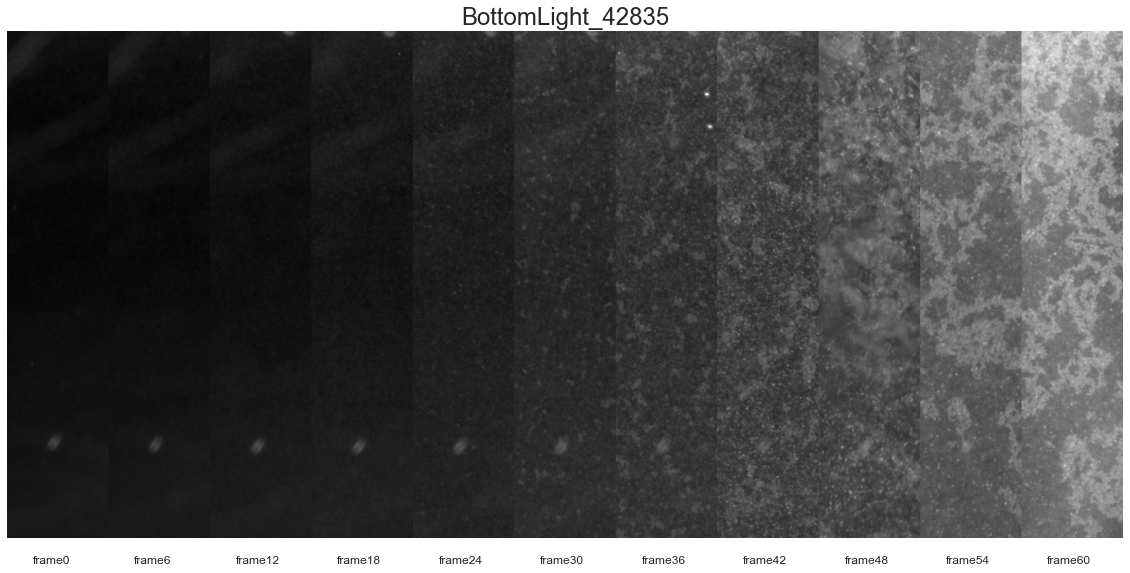

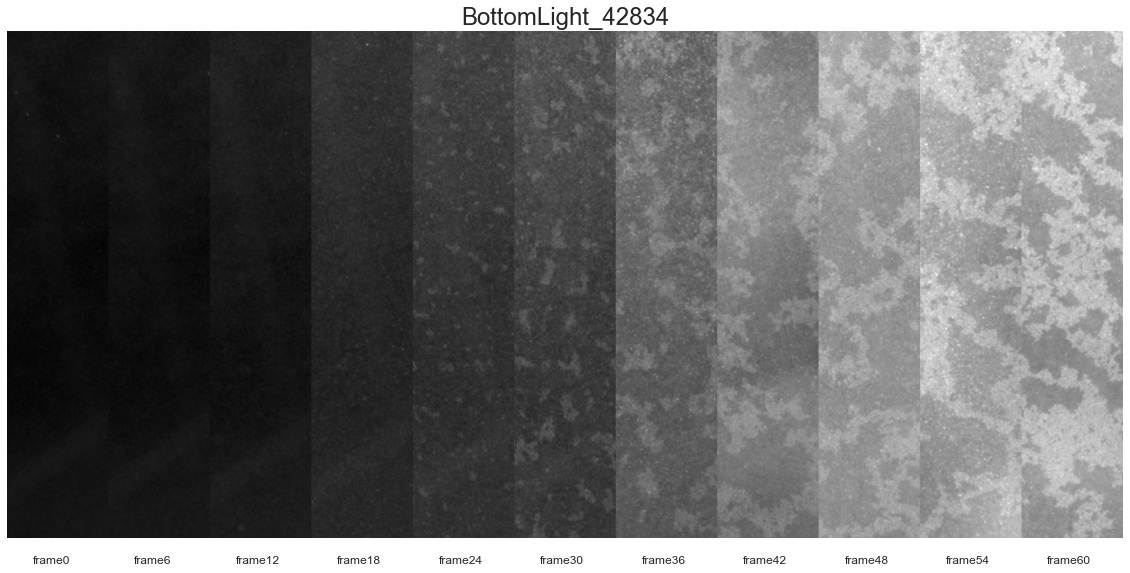

In [173]:
for (name,images) in images_dict.items():
    Plot_layer_time(images,Rectangle_Layer,6,name)